# Numerical Solution of the Burgers' Equation

## Problem Statement :

<span style="color: royalblue"> We aim to simulate the **Burgers' equation** on the domain \( x belongs to [0, 1] \) with the following conditions:</span>



 $$ \color{blacck}\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$



- <span style="color: orange"> **Boundary Conditions:**  </span>
    - $ u(0, t) = U_L $ left boundary
    - $ u(1, t) = U_R $ right boundary &nbsp;  

- <span style="color: orange">**Initial Condition:** </span>
    - $ u(x, 0) = 1 $  for  $ x < 0.5 $, and $ u(x, 0) = 0 $ otherwise   &nbsp;   &nbsp;  &nbsp;


## The Cole-Hopf Transformation

<span style="color: royalblue">The Cole-Hopf transformation linearizes the Burgers' equation:</span>

1. <span style="color: orange">**Transformation:**</span>
      
      
      $$ \color{blacck} u(x,t) = -2\nu \frac{\partial}{\partial x} \ln \phi(x,t) $$
<span style="color: royalblue">where  $ \phi(x, t) $  satisfies the heat equation:</span>
     
-    $$ \color{blacck} \frac{\partial \phi}{\partial t} = \nu \frac{\partial^2 \phi}{\partial x^2} $$

2. <span style="color: orange">**Initial Condition :**</span>
 $$
     \color{blacck}\phi(x, 0) = \exp\left(-\frac{1}{2\nu} \int_0^x u_0(y) dy \right)
    $$

## The Numerical Solution: Crank-Nicolson Method

<span style="color: royalblue">To simulate the time evolution numerically, we use the Crank-Nicolson method:</span>
    

-<span style="color: orange">**Discretization:**</span>
    The spatial domain is discretized into grid points and Crank-Nicolson is applied to heat equation for $ \phi $.

-<span style="color: orange">**Time Stepping:**  </span>
    At each time step, solve for $ \phi(x, t) $, then recover $ u(x, t) $ using the Cole-Hopf transformation.

-<span style="color: orange">**Boundary Conditions:**  </span>
    Apply the specified Dirichlet boundary conditions for $ u $ at $ x=0 $ and $ x=1 $.

In [ ]:
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt

# Simulate Burgers' equation using Cole-Hopf transformation and Crank-Nicolson scheme
def simulate_burgers_cole_hopf(nu, L, Nx, T, dt, snapshot_times=[]):
    dx = L / (Nx - 1)
    x = np.linspace(0, L, Nx)
    
# Initial condition: Riemann step (u=1 for x<=0.5, u=0 otherwise)
    u0 = np.where(x <= 0.5, 1.0, 0.0)

# Compute integral for Cole-Hopf initial transformation
    integral = np.zeros(Nx)
    for i in range(1, Nx):
        # Trapezoidal rule for integration
        integral[i] = integral[i-1] + 0.5 * (u0[i] + u0[i-1]) * dx
    phi = np.exp(-integral / (2 * nu))
    
# Crank-Nicolson matrices for time-stepping the heat equation
    r = nu * dt / dx**2
    A = np.eye(Nx)
    B = np.eye(Nx)
    for i in range(1, Nx-1):
# Fill in tridiagonal entries for interior points
        A[i, i-1] = -r/2
        A[i, i]   = 1 + r
        A[i, i+1] = -r/2
        B[i, i-1] = r/2
        B[i, i]   = 1 - r
        B[i, i+1] = r/2
# Neumann boundary conditions for phi (zero derivative at boundaries)
    A[0,0] = A[-1,-1] = 1
    A[0,1] = A[-1,-2] = 0
    B[0,0] = B[-1,-1] = 1
    B[0,1] = B[-1,-2] = 0
    
    Nt = int(T/dt)
    times = np.arange(0, T+dt/2, dt)
    snapshot_indices = [int(round(t/dt)) for t in snapshot_times]
    
    phi_hist = []
    phi_hist.append(phi.copy())
    for n in range(Nt):
        b = B @ phi
# Apply boundary conditions for phi at each step
        b[0] = phi[0]
        b[-1] = phi[-1]
        phi_new = solve(A, b)
        phi = phi_new
# Save snapshots at requested times
        if (n+1) in snapshot_indices:
            phi_hist.append(phi.copy())
    
    u_hist = []

    for idx, phi_snap in enumerate(phi_hist):
# Recover u from phi using Cole-Hopf formula
        lnphi = np.log(np.maximum(phi_snap, 1e-14))
        dlnphi_dx = np.zeros_like(lnphi)
# Use central differences for interior, one-sided for boundaries
        dlnphi_dx[1:-1] = (lnphi[2:] - lnphi[:-2])/(2*dx)
        dlnphi_dx[0] = (-3*lnphi[0] + 4*lnphi[1] - lnphi[2])/(2*dx)
        dlnphi_dx[-1] = (3*lnphi[-1] - 4*lnphi[-2] + lnphi[-3])/(2*dx)
        u_hist.append(-2*nu*dlnphi_dx)
    return x, snapshot_times, np.array(u_hist)


## Plot the Graph

In [44]:
# Plot the solution snapshots at selected times
def plot_snapshots(x, snapshot_times, u_hist):
    plt.figure(figsize=(16,7))
    for i, (t, u) in enumerate(zip(snapshot_times, u_hist)):
        plt.plot(x, u, label=f"t = {t:.1f} s", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title("Burgers' Equation via Cole-Hopf (Riemann Step: Evolution over Time)")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.ylim(-0.1, 1.05)
    plt.xlim(0, 1)
    plt.show()


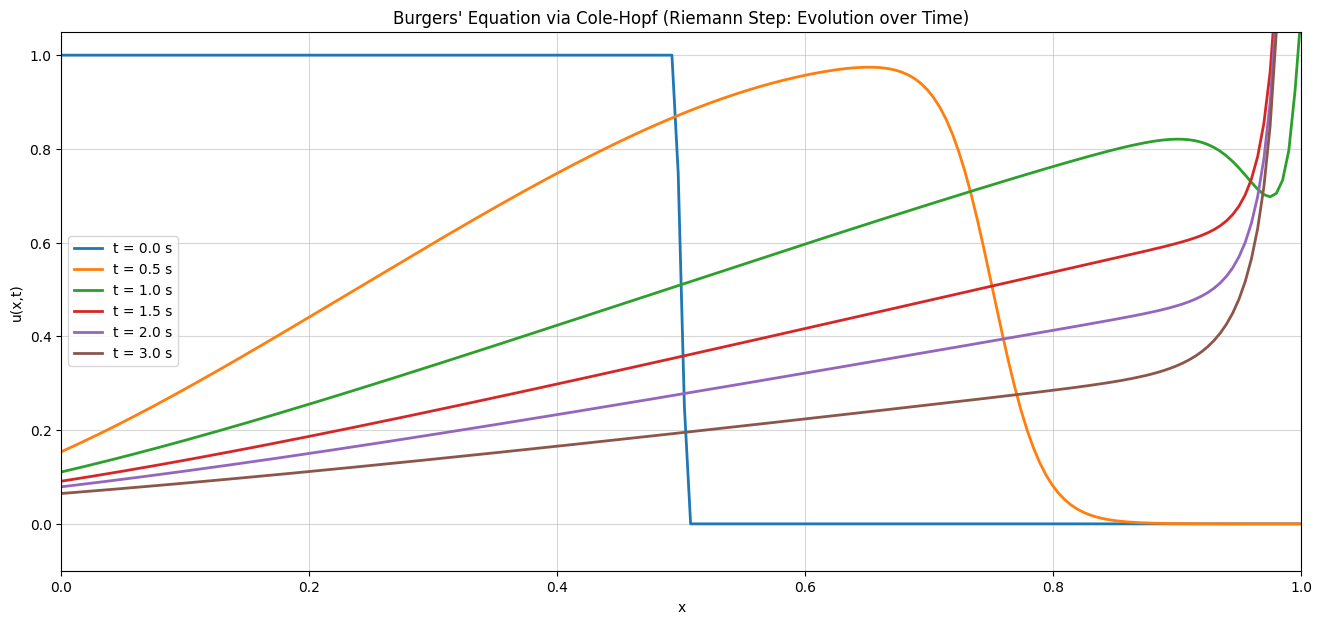

In [46]:
x, snapshot_times, u_hist = simulate_burgers_cole_hopf( nu=0.01, L=1.0, Nx=200, T=4.0, dt=0.001, snapshot_times=[0.0, 0.5, 1.0, 1.5,2 ,3] )
# print(u_hist)
plot_snapshots(x, snapshot_times, u_hist)
